# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extensions

In [2]:
# Load the rpy2 IPython extension
%load_ext rpy2.ipython

# Data

In [3]:
# Load data
df = pd.read_csv('alberta_monthly_area_burned.csv')

# Output first 5 rows of dataset
df.head()

,DATE,AREA_BURNED_HA,LOG_AREA_BURNED_HA
0,1959-04,317.41,2.502987
1,1959-05,7515.69,3.876027
2,1959-06,0.00,0.000000
3,1959-07,15220.63,4.182461
4,1959-08,0.00,0.000000


In [4]:
# Convert the 'DATE' column to a datetime format
df['DATE'] = pd.to_datetime(df['DATE'],
                            format='%Y-%m')

# Add column containing year
df['YEAR'] = df['DATE'].dt.year

# Add column containing month
df['MONTH'] = df['DATE'].dt.month

# Output first 12 rows of dataset
df.head(12)

,DATE,AREA_BURNED_HA,LOG_AREA_BURNED_HA,YEAR,MONTH
0,1959-04-01,317.41,2.502987,1959,4
1,1959-05-01,7515.69,3.876027,1959,5
2,1959-06-01,0.00,0.000000,1959,6
3,1959-07-01,15220.63,4.182461,1959,7
4,1959-08-01,0.00,0.000000,1959,8
5,1959-09-01,0.00,0.000000,1959,9
6,1959-10-01,0.00,0.000000,1959,10
7,1959-11-01,0.00,0.000000,1959,11
8,1959-12-01,0.00,0.000000,1959,12
9,1960-01-01,0.00,0.000000,1960,1


# Modelling

In [5]:
# Transfer DataFrame from Python to R
%R -i df

## STL

In [6]:
%%R

# Convert 'LOG_AREA_BURNED_HA' column to R time series object 
log_area_burned_ha_ts = ts(df$LOG_AREA_BURNED_HA,
                            start=c(1959, 4),
                            end=c(2021, 12),
                            frequency=12)

# Fit STL
stl = stl(log_area_burned_ha_ts,
           s.window="periodic", # Assumes constant seasonality
           robust=TRUE) # Robustness iterations are used

# Get components
stl_trend = stl$time.series[, "trend"]
stl_seasonal = stl$time.series[, "seasonal"]
stl_remainder = stl$time.series[, "remainder"]

In [7]:
# Convert data frames from R to Python
%R -o stl_trend
%R -o stl_seasonal
%R -o stl_remainder

## GAM

In [8]:
%%R -o gam_intercept

# Load 'mcgv' package
suppressMessages(suppressWarnings(library(mgcv)))

# Fit GAM
gam = gam(LOG_AREA_BURNED_HA ~ s(MONTH) + s(YEAR),
          data=df,
          method='REML')

# Get intercept from fitted GAM
gam_intercept = coef(gam)[1]

# Output summary of fitted GAM
summary(gam)


Family: gaussian 
Link function: identity 

Formula:
LOG_AREA_BURNED_HA ~ s(MONTH) + s(YEAR)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.85012    0.03426      54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
           edf Ref.df     F p-value    
s(MONTH) 8.175  8.818 128.7  <2e-16 ***
s(YEAR)  3.083  3.833  12.1  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.61   Deviance explained = 61.6%
-REML =   1044  Scale est. = 0.88398   n = 753


In [9]:
%%R -o seasonal_gam -o trend_gam

# Load 'lubridate' package
suppressMessages(suppressWarnings(library(lubridate)))

# Create data frame containing two columns. The first column contains data to be inputted into seasonal smoother
# to make predictions. The second column contains data to be inputted into the trend smoother to make predictions.
month_prediction_data = seq(min(df$MONTH),
                            max(df$MONTH),
                            length.out=100)
year_prediction_data = seq(min(df$YEAR),
                           max(df$YEAR),
                           length.out=100)
prediction_data = data.frame(MONTH=month_prediction_data,
                             YEAR=year_prediction_data)

# Input first column into seasonal smoother to get predictions. Input second column into trend smoother to get predictions.
smoother_pred = predict(gam,
                        newdata = prediction_data,
                        type = "terms")
month_smoother_pred = smoother_pred[, "s(MONTH)"]
year_smoother_pred = smoother_pred[, "s(YEAR)"]

# Create data frame containing predictions for data inputed into seasonal smoother
seasonal_gam = data.frame(Month=month_prediction_data,
                          Seasonal=month_smoother_pred)

# Create data frame containing predictions for data inputed into trend smoother
date = format(date_decimal(year_prediction_data), '%Y-%m-%d') # Convert decimal year to date format
trend_gam = data.frame(Date=date,
                       Trend=year_smoother_pred)

# Plotting

## STL

In [10]:
# Create DataFrame containing STL results
df_stl = pd.DataFrame({'LOG_AREA_BURNED_HA': df['LOG_AREA_BURNED_HA'].values,
                       'Seasonal': stl_seasonal,
                       'Trend': stl_trend,
                       'Remainder': stl_remainder},
                       index=df['DATE'])

# Output first 5 rows of DataFrame containing STL results
df_stl.head()

,LOG_AREA_BURNED_HA,Seasonal,Trend,Remainder
DATE,,,,
1959-04-01,2.502987,0.767437,1.891595,-0.156046
1959-05-01,3.876027,1.621846,1.783597,0.470584
1959-06-01,0.000000,1.790685,1.675599,-3.466284
1959-07-01,4.182461,1.572943,1.575313,1.034205
1959-08-01,0.000000,0.647779,1.475026,-2.122805


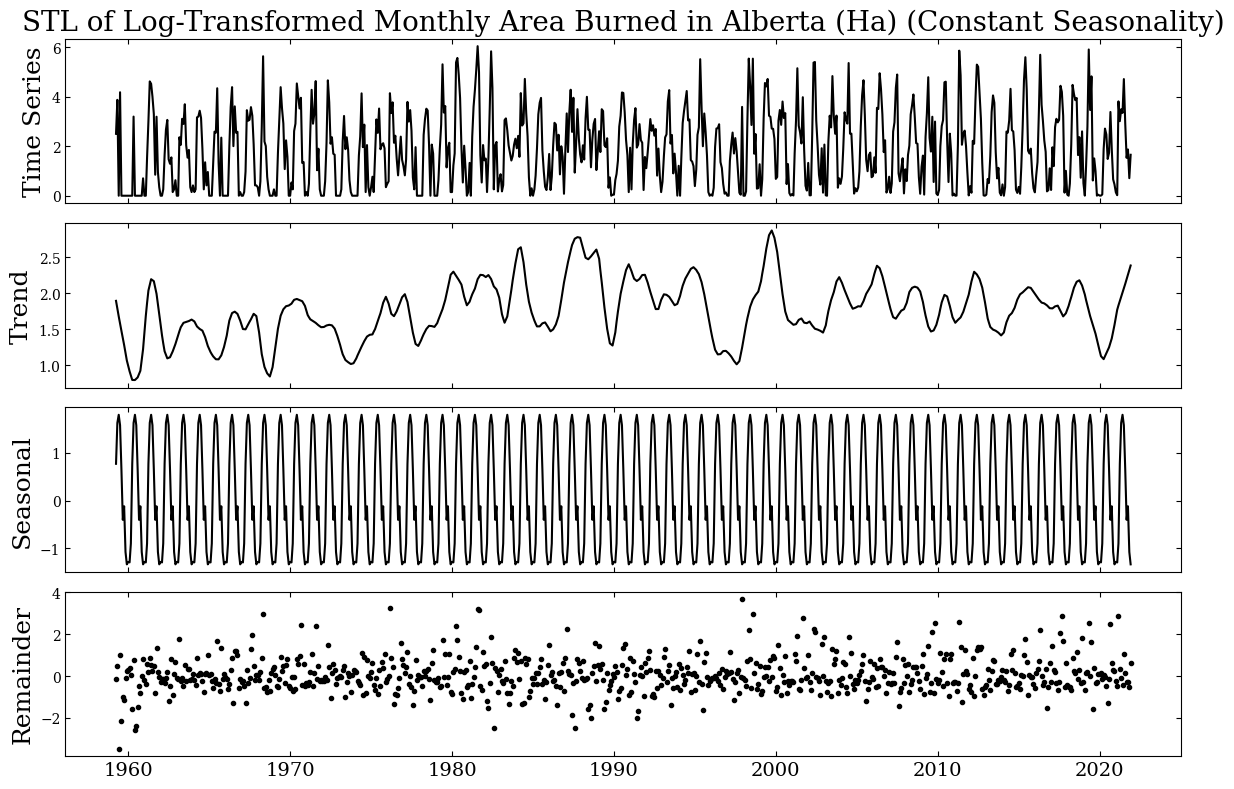

In [11]:
# Set font style
plt.rc('font', family='serif')

# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Retrieve components
observed = df_stl.LOG_AREA_BURNED_HA
seasonal = df_stl.Seasonal
trend = df_stl.Trend
remainder = df_stl.Remainder

# Plot each component
ax[0].plot(observed, color='k')
ax[0].set_title('STL of Log-Transformed Monthly Area Burned in Alberta (Ha) (Constant Seasonality)', fontsize=20)
ax[0].set_ylabel('Time Series', fontsize=18)

ax[1].plot(trend, color='k')
ax[1].set_ylabel('Trend', fontsize=18)

ax[2].plot(seasonal, color='k')
ax[2].set_ylabel('Seasonal', fontsize=18)

ax[3].plot(remainder, linestyle='none', marker='o', markersize=3, color='k')
ax[3].set_ylabel('Remainder', fontsize=18)
ax[3].tick_params(axis='x', labelsize=14)

# Make ticks face inward. Add ticks to top and right side of plot.
for i in range(0, 4):
    ax[i].tick_params(direction='in', top=True, right=True)

# Automatically adjust spacing in plot
plt.tight_layout()

# Show plot
plt.show()

## GAM

In [12]:
# Make month index in DataFrame containing seasonal smoother predictions 
seasonal_gam = seasonal_gam.set_index('Month')

# Output first 5 rows of DataFrame containing seasonal smoother predictions
seasonal_gam.head()

,Seasonal
Month,
1.000000,-1.357514
1.111111,-1.356232
1.222222,-1.354664
1.333333,-1.352525
1.444444,-1.349532


In [13]:
# Make date index in DataFrame containing trend smoother predictions 
trend_gam = trend_gam.set_index('Date')

# Make index datetime format
trend_gam.index = pd.to_datetime(trend_gam.index)

# Output first 5 rows of DataFrame containing trend smoother predictions 
trend_gam.head()

,Trend
Date,
1959-01-01,-0.650338
1959-08-17,-0.624315
1960-04-02,-0.598325
1960-11-17,-0.572410
1961-07-04,-0.546622


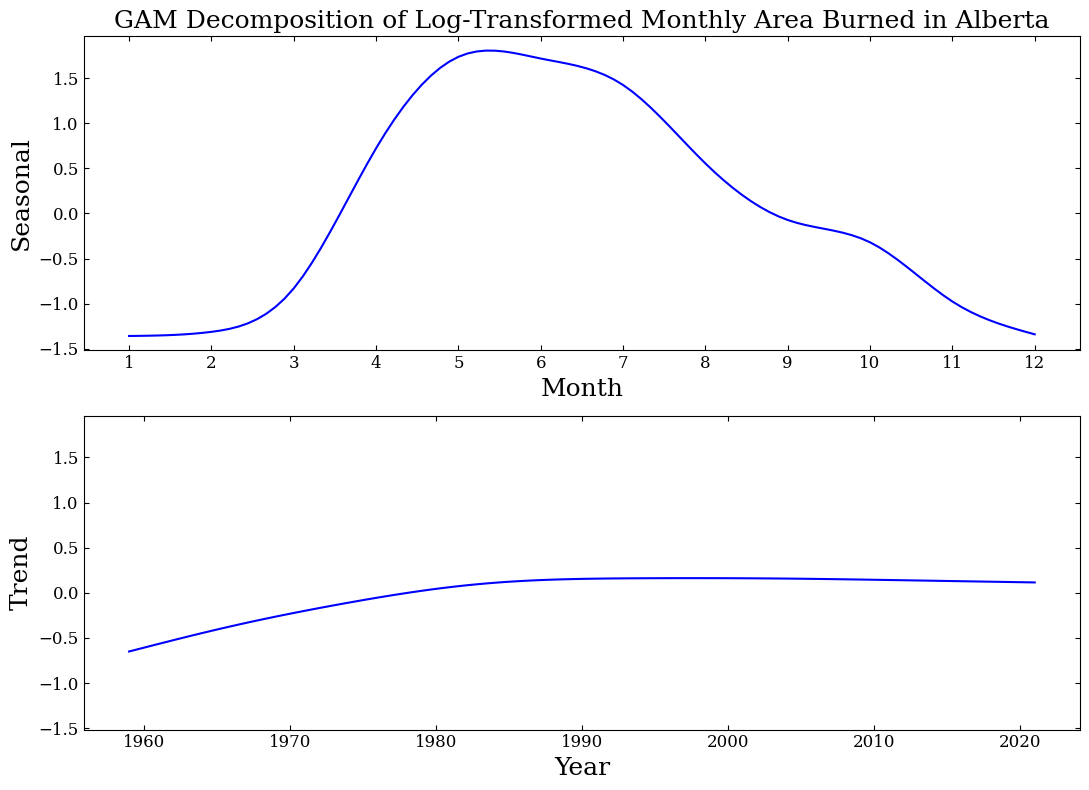

In [14]:
# Set font style
plt.rc('font', family='serif')

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(11, 8), sharey=True)

# Plot seasonal component obtained using GAM
ax[0].plot(seasonal_gam, color='b')
ax[0].set_title('GAM Decomposition of Log-Transformed Monthly Area Burned in Alberta', fontsize=18)
ax[0].set_ylabel('Seasonal', fontsize=18)
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].set_xticks(np.arange(1, 13))
ax[0].set_xlabel('Month', fontsize=18)

# Plot trend component obtained using GAM
ax[1].plot(trend_gam, color='b')
ax[1].set_ylabel('Trend', fontsize=18)
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].set_xlabel('Year', fontsize=18)

# Make ticks face inward. Add ticks to top and right side of plot.
for i in range(0, 2):
    ax[i].tick_params(direction='in', top=True, right=True)

# Automatically adjust spacing in plot
plt.tight_layout()

# Show plot
plt.show()

## Comparison

### Trend

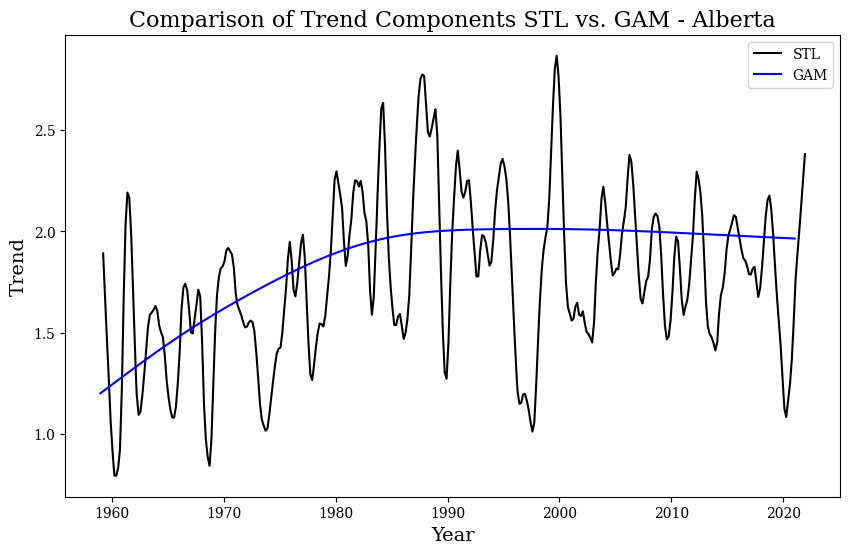

In [15]:
# Set figure size
plt.figure(figsize=(10, 6))

# Set font style
plt.rc('font', family='serif')

# Plot the trend obtained using stl 
plt.plot(df_stl.index, df_stl['Trend'],
         label='STL',
         color='k')

# Plot the trend obtained using the GAM
plt.plot(trend_gam.index, trend_gam['Trend'] + gam_intercept,
         label='GAM',
         color='b')

# Add title and axis names
plt.title('Comparison of Trend Components STL vs. GAM - Alberta', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Trend', fontsize=14)

# Add legend
plt.legend()

# Show plot
plt.show()

### Seasonal

In [16]:
# Get seasonal components in 2021 (Since seasoal component is assumed to be constant this will be the seasonal components for all years)
month_seasonal_component_stl = df_stl[df_stl.index.year == 2021]['Seasonal']

# Make index month
month_seasonal_component_stl.index = month_seasonal_component_stl.index.month

# Rename index 'Month'
month_seasonal_component_stl.index.name = 'Month'

# Output seasonal component associated with each month obtained using STL
pd.DataFrame(month_seasonal_component_stl)

,Seasonal
Month,
1,-1.281754
2,-1.292710
3,-0.896131
4,0.767437
5,1.621846
6,1.790685
7,1.572943
8,0.647779
9,-0.402604


In [17]:
# Get seasonal component associated with each month obtained using a GAM
month_seasonal_component_gam = seasonal_gam[seasonal_gam.index.isin(np.arange(0, 13))]

# Output seasonal component associated with each month obtained using a GAM
month_seasonal_component_gam

,Seasonal
Month,
1.0,-1.357514
2.0,-1.311745
3.0,-0.830371
4.0,0.721759
5.0,1.735420
6.0,1.716367
7.0,1.423388
8.0,0.554187
9.0,-0.072516


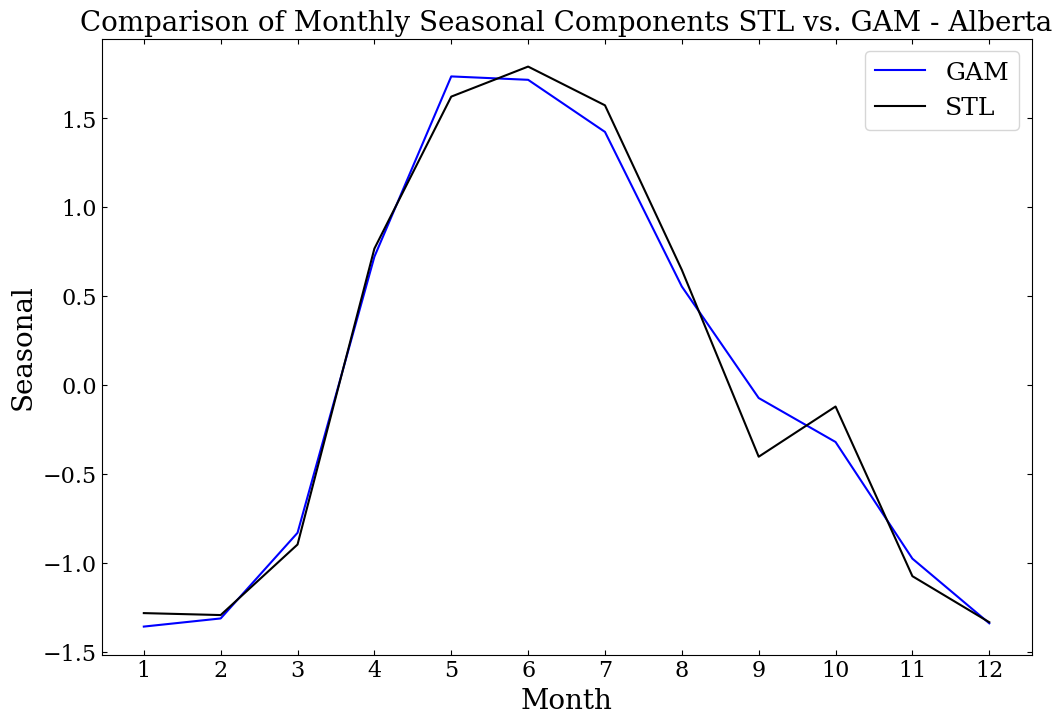

In [18]:
# Set figure size
plt.figure(figsize=(12, 8))

# Set font style
plt.rc('font', family='serif')

# Plot seasonal component using GAM approach 
plt.plot(month_seasonal_component_gam,
         label='GAM',
         color='b')

# Plot seasonal component using STL approach
plt.plot(month_seasonal_component_stl,
         label='STL',
         color='k')

# Add title and axis names
plt.title('Comparison of Monthly Seasonal Components STL vs. GAM - Alberta',
          fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Seasonal', fontsize=20)

# Set x ticks and increase tick label size in both axis
plt.xticks(range(1, 13), fontsize=16)
plt.yticks(fontsize=16)

# Make ticks face inward. Add ticks to top and right side of plot.
plt.tick_params(direction='in', top=True, right=True)

# Add legend 
plt.legend(fontsize=18)

# Show plot
plt.show()